In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re, random, pickle, glob, os, difflib
import numpy as np
from sklearn import metrics
from utils import *
import tensorflow as tf

In [2]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'plots/'
train_set = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [3]:
dvf = pd.read_csv('test/test_easy_1.csv', index_col=0)
# deepvirfinder comparison
dvf_true = dvf[dvf.names.str.contains('gi')]['scores'].to_numpy()
dvf_false = dvf[~dvf.names.str.contains('gi')]['scores'].to_numpy()

dvf_fpr = []
dvf_tpr = []
precision = []

for i in range (100):
    fp = np.sum(dvf_false>=(i/100))/len(dvf_false)
    tp = np.sum(dvf_true>=(i/100))/len(dvf_true)
    dvf_fpr.append(fp)
    dvf_tpr.append(tp)
metrics.auc(dvf_fpr, dvf_tpr)

0.5735314579611708

In [4]:
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
test_reads_1 = np.delete(test_reads_1, 3, axis=2)
test_reads_1 = np.expand_dims(test_reads_1, -1)

(105492, 2)


In [5]:
vanilla = tf.keras.models.load_model('models/vanilla_vae/6_16_0.7328388135293772')
beta = tf.keras.models.load_model('models/beta_vae/batch2048_width256_fsize10_latentdim32_beta0.1_0.31241775779823716')

In [6]:
vanilla_pred = vanilla.predict(test_reads_1, verbose=1)
vanilla_pred = tf.keras.losses.binary_crossentropy(test_reads_1, vanilla_pred)
vanilla_pred = tf.reduce_mean(vanilla_pred, [1,2])

beta_pred = beta.predict(test_reads_1, verbose=1)
beta_pred = tf.keras.losses.binary_crossentropy(test_reads_1, beta_pred)
beta_pred = tf.reduce_mean(beta_pred, [1,2])

3297/3297 [==============================] - 45s 14ms/step


In [7]:
vanilla_fpr, vanilla_tpr, _ = metrics.roc_curve(np.array(easy_1.viral), vanilla_pred)
beta_fpr, beta_tpr, _ = metrics.roc_curve(np.array(easy_1.viral), beta_pred)
metrics.auc(vanilla_fpr, vanilla_tpr), metrics.auc(beta_fpr, beta_tpr)

(0.7328390294654601, 0.3124177774287901)

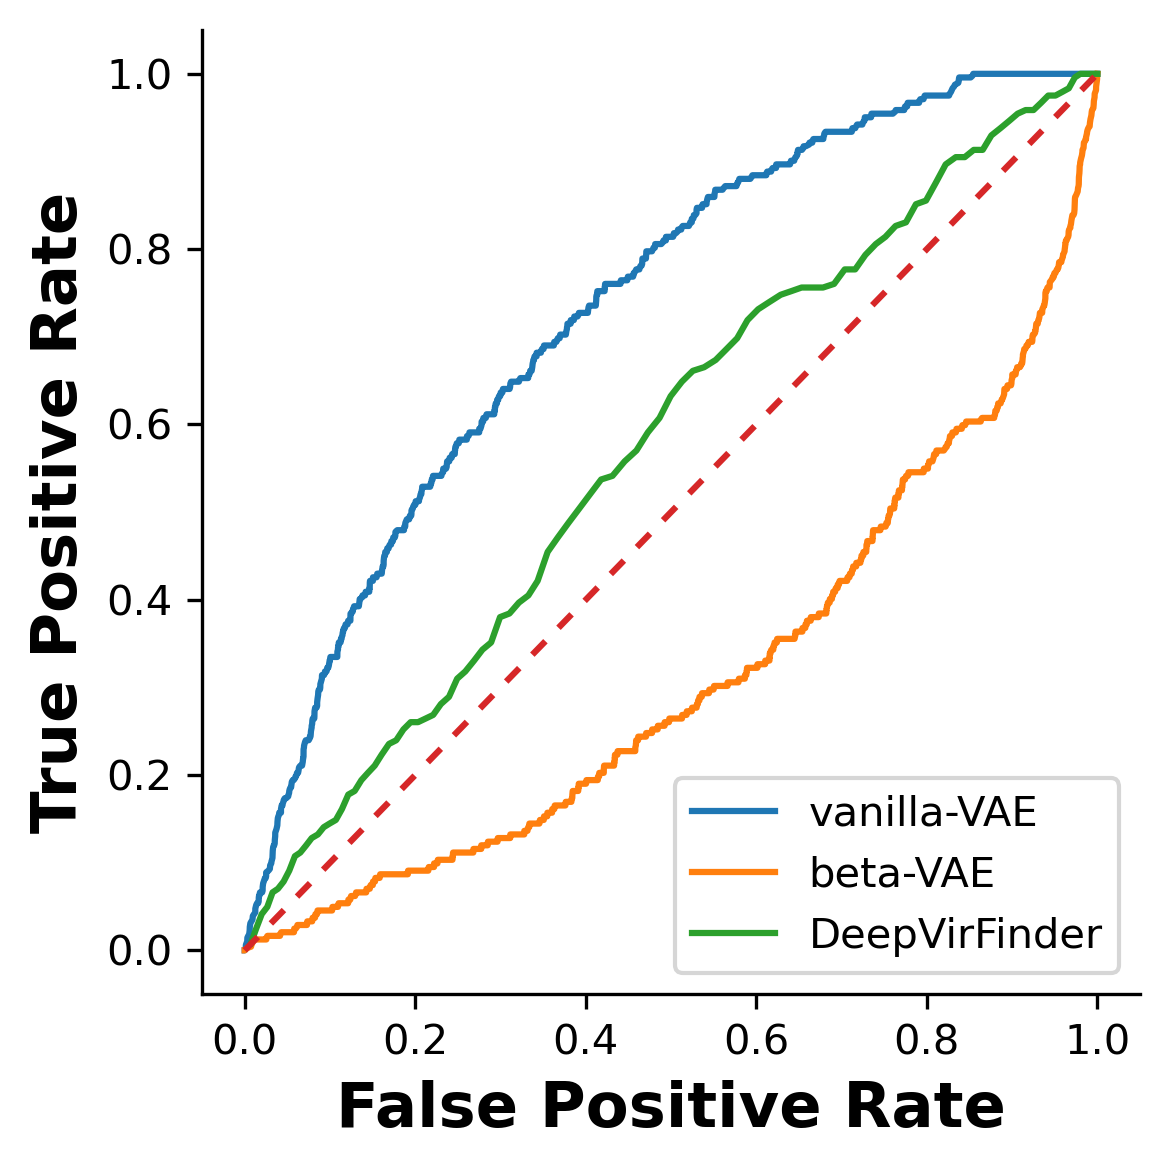

In [10]:
fig,ax=plt.subplots(num=None, dpi = 300, figsize=(4, 4), facecolor='w', edgecolor='k')
sns.lineplot(vanilla_fpr, vanilla_tpr, ax=ax)
sns.lineplot(beta_fpr, beta_tpr, ax=ax)
sns.lineplot(dvf_fpr, dvf_tpr, ax=ax)
sns.lineplot([0, 1], [0, 1], style=True, dashes=[(3,3)], ax=ax)
plt
ax.legend(['vanilla-VAE', 'beta-VAE', 'DeepVirFinder'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
label_font = {'weight':'bold', 'size':'15'};
plt.xlabel('False Positive Rate', label_font); plt.ylabel('True Positive Rate', label_font); plt.tight_layout();
plt.savefig('plots/milestone_roc.png')

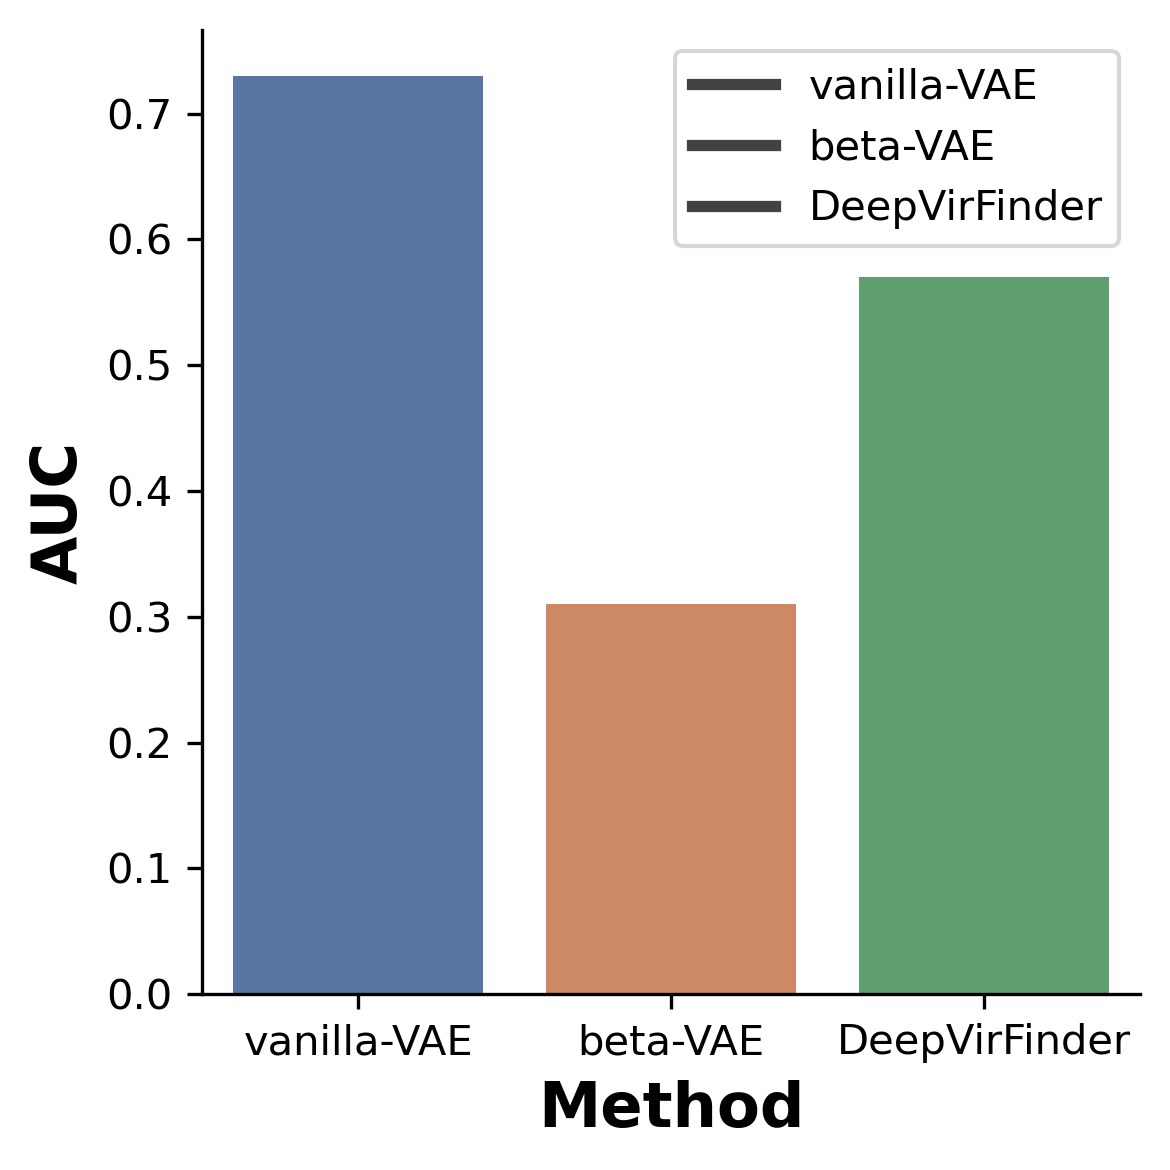

In [11]:
fig,ax=plt.subplots(num=None, dpi = 300, figsize=(4, 4), facecolor='w', edgecolor='k')
sns.barplot(['vanilla-VAE', 'beta-VAE', 'DeepVirFinder'], [0.73, 0.31, 0.57], palette = 'deep', ax=ax)
ax.legend(['vanilla-VAE', 'beta-VAE', 'DeepVirFinder'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.xlabel('Method', label_font); plt.ylabel('AUC', label_font); plt.tight_layout()
plt.savefig('plots/milestone_auc.png')